In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.vgg16 import VGG16 
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import numpy as np
import seaborn as sns
import pandas as pd

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import pickle

data_path = '/content/drive/MyDrive/Belgeler'

Xfile = open(data_path + "/X.pickle", "rb")
yfile = open(data_path + "/y.pickle", "rb")

X = pickle.load(Xfile)
y = pickle.load(yfile)

In [ ]:
X_test_file = open(data_path + "/X_test_rgb.pickle", "rb")
y_test_file = open(data_path + "/y_test_rgb.pickle", "rb")

X_test = pickle.load(X_test_file)
y_test = pickle.load(y_test_file)

In [ ]:
print(" y shape " + str(y.shape) + " X shape " + str(X.shape) + " y type " + str(type(y)) + " X type " + str(type(X)))

 y shape (28709,) X shape (28709, 48, 48, 1) y type <class 'numpy.ndarray'> X type <class 'numpy.ndarray'>


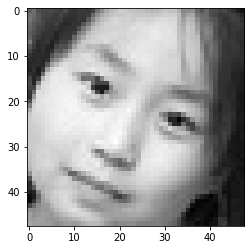

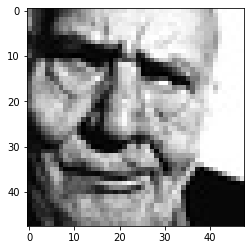

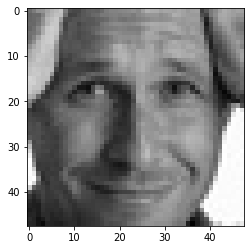

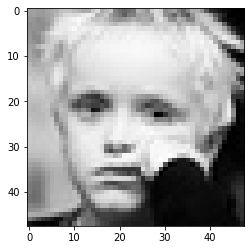

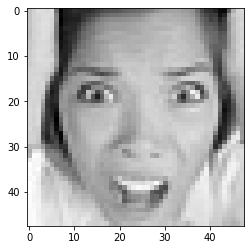

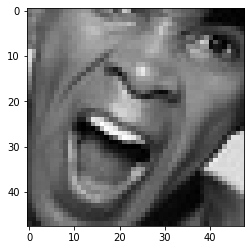

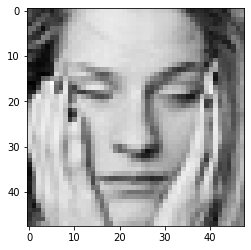

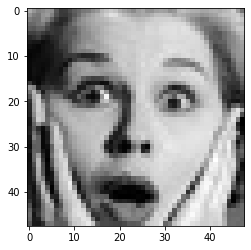

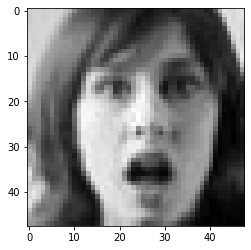

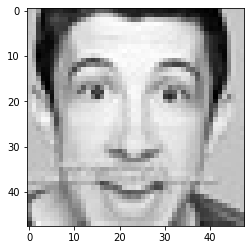

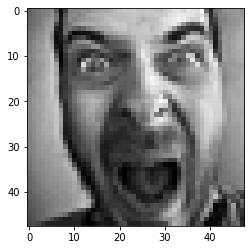

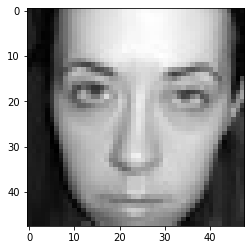

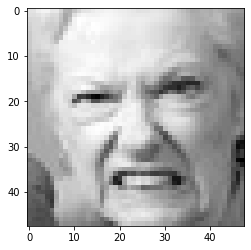

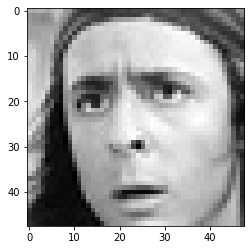

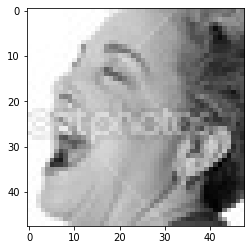

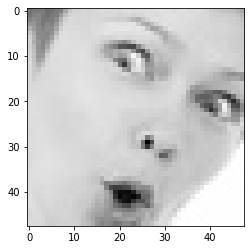

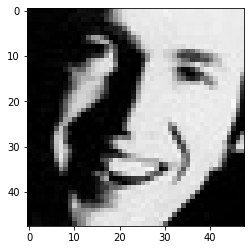

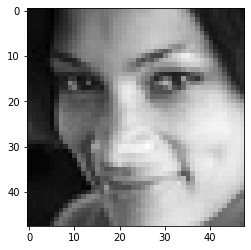

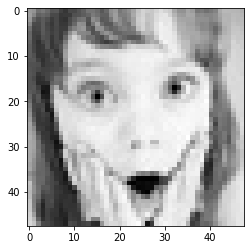

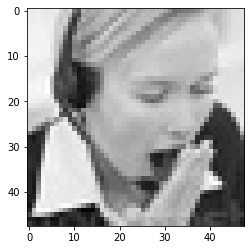

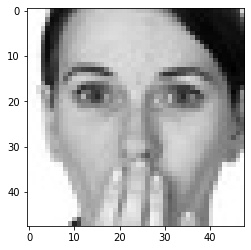

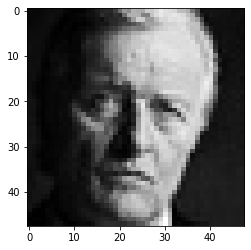

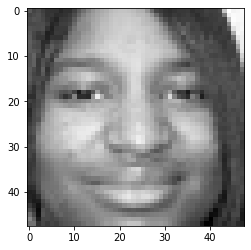

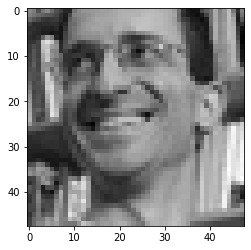

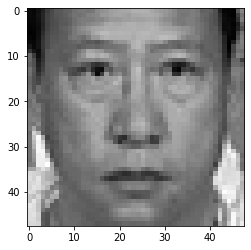

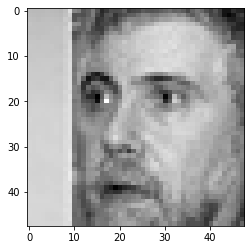

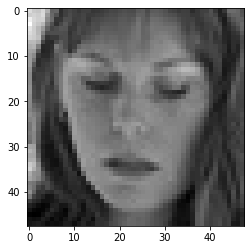

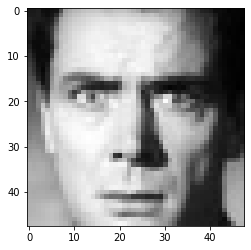

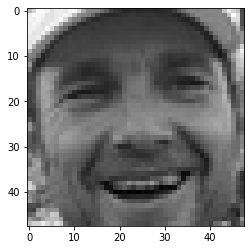

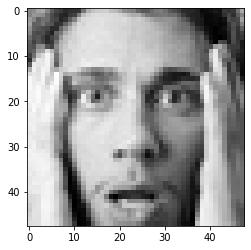

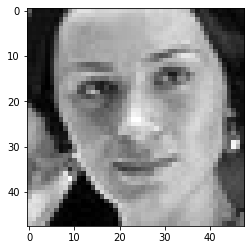

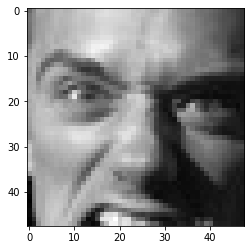

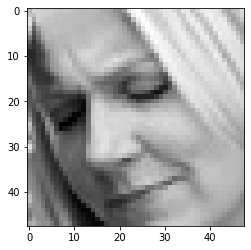

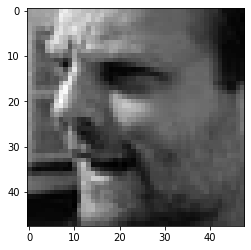

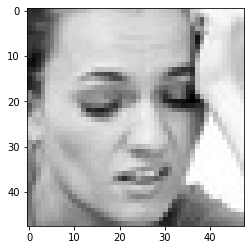

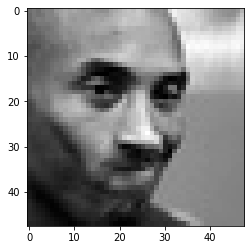

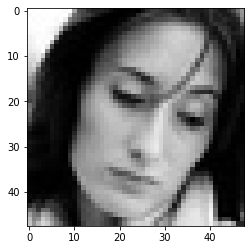

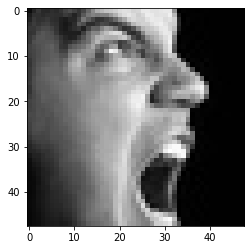

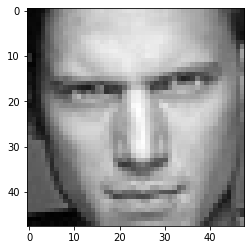

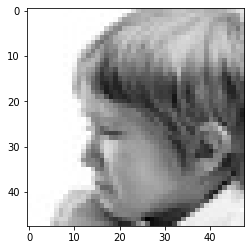

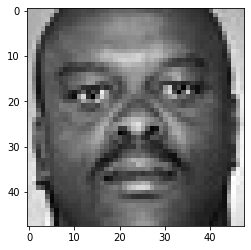

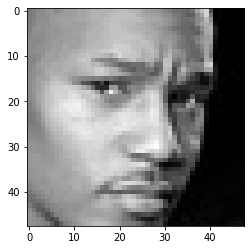

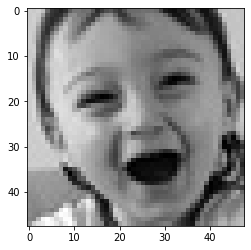

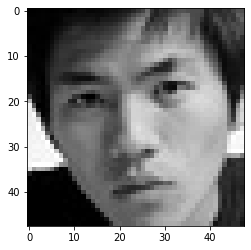

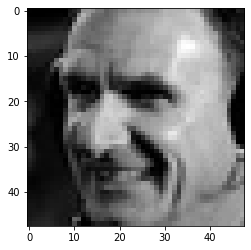

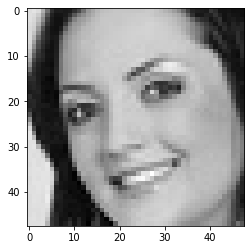

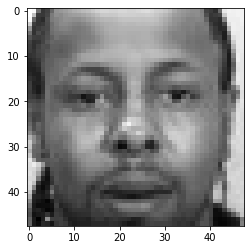

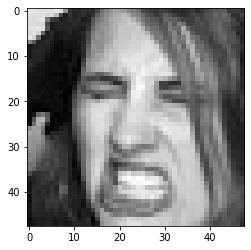

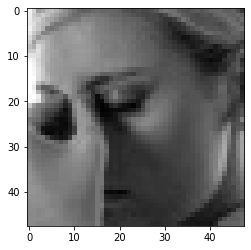

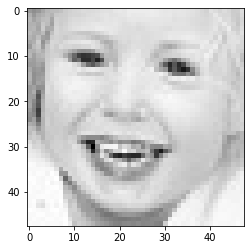

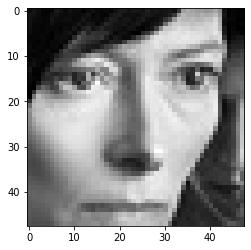

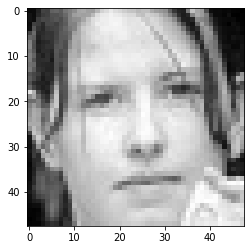

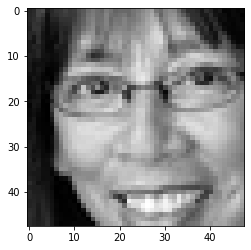

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(0, len(X[:1500])):
  img_shape = cv2.resize(X[i], (48, 48))
  plt.imshow(img_shape, cmap="gray")
  plt.show()

In [ ]:
train_data = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    horizontal_flip=True 
)

test_data = ImageDataGenerator(rescale=1./255)

In [ ]:
X_train_gen = train_data.flow_from_directory(
    "/content/drive/MyDrive/Datasets/archive/train",
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical"
)

X_val = test_data.flow_from_directory(
    "/content/drive/MyDrive/Datasets/archive/test",
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical"
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint

class_weights = class_weight.compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(X_train_gen.classes),
    y = X_train_gen.classes)

num_classes=7
keys=range(num_classes)
values = class_weights.copy()
class_weights = dict(zip(keys, values))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [ ]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(48, 48, 3))
for layer in base_model.layers[:10]:
  layer.trainable=False

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
#X_train = image_dataset_from_directory(
    #directory= "/content/drive/MyDrive/Datasets/archive/train/",
    #labels = "inferred",
    #label_mode = "int",
    #batch_size = 1,
    #color_mode = "rgb",
    #image_size = (200, 200))

#X_vali = image_dataset_from_directory(
    #directory = "/content/drive/MyDrive/Datasets/archive/test/",
    #labels = "inferred",
    #label_mode = "int",
    #batch_size = 1,
    #color_mode = "rgb",
    #image_size = (200, 200))

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [ ]:
#X = X/255.0 
model = Sequential()
model.add(base_model)
#model.add(Conv2D(75, (3,3), strides=2, padding="same", activation="relu", input_shape=(48, 48, 1))) #(48, 48, 1) olmayacak input_shape
#model.add(BatchNormalization())
#model.add(MaxPool2D((2,2), strides=2, padding="same")) #strides 2 

In [ ]:
#model.add(Conv2D(50, (3,3), strides=2, padding="same", activation="relu")) 
#model.add(Dropout(0.2)) #0.2
#model.add(BatchNormalization())

In [ ]:
#model.add(MaxPool2D((2,2), strides=2, padding="same")) #stride2 2
#model.add(Conv2D(25, (3,3), strides=2, padding="same", activation="relu")) 
#model.add(BatchNormalization())

In [ ]:
#model.add(MaxPool2D((2,2), strides=2, padding="same")) #strides 2
model.add(Flatten())
model.add(Dense(units=64, activation="relu"))

In [ ]:
model.add(Dropout(0.3)) #0.2 yap
model.add(Dense(units=7, activation="softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 14,747,975
Trainable params: 13,012,487
Non-trainable params: 1,735,488
_________________________________________________________________


In [ ]:
optimizer_1=SGD(learning_rate=0.01)
model.compile(optimizer=optimizer_1, loss="categorical_crossentropy", metrics=["acc"]) #rmsprop yerine adam kullandım
#SGD kullandım batch size 256 epoch 200 SGD(learning_rate=0.01, momentum, nesterov=False, name='SGD')
#adadelta kullandım batch size 256 200 değişmeyecek #Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-07, name=adadelta)
#Adam(0.001)
#model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
#early_stop = EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True) 
#model.fit(X, y, epochs=200, batch_size = 256, callbacks=[early_stop], validation_split=0.3) #batch size 256 #X ve y validation_split 
history = model.fit_generator(
    X_train_gen,
    epochs=70,
    verbose=1,
    class_weight=class_weights,
    validation_data=X_val
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/70
449/449 [==============================] - 7159s 16s/step - loss: 1.8144 - acc: 0.2696 - val_loss: 1.5593 - val_acc: 0.4136
Epoch 2/70
449/449 [==============================] - 111s 248ms/step - loss: 1.6352 - acc: 0.3627 - val_loss: 1.4493 - val_acc: 0.4482
Epoch 3/70
449/449 [==============================] - 111s 247ms/step - loss: 1.5241 - acc: 0.4164 - val_loss: 1.3559 - val_acc: 0.4813
Epoch 4/70
449/449 [==============================] - 112s 250ms/step - loss: 1.4408 - acc: 0.4497 - val_loss: 1.3170 - val_acc: 0.4894
Epoch 5/70
449/449 [==============================] - 111s 248ms/step - loss: 1.3868 - acc: 0.4695 - val_loss: 1.2473 - val_acc: 0.5311
Epoch 6/70
449/449 [==============================] - 115s 255ms/step - loss: 1.3341 - acc: 0.4897 - val_loss: 1.2059 - val_acc: 0.5361
Epoch 7/70
449/449 [==============================] - 115s 257ms/step - loss: 1.2967 - acc: 0.5033 - val_loss: 1.2041 - val_acc: 0.5444
Epoch 8/70
449/449 [=============================

In [11]:
#acc = history.history['acc']
#val_acc = history.history['val_acc']
#loss = history.history['loss']
#val_loss = history.history['val_loss']
#epochs = range(1, len(acc) + 1)

#plt.title('Training and validation accuracy')
#plt.plot(epochs, acc, 'red', label='Training acc')
#plt.plot(epochs, val_acc, 'blue', label='Validation acc')
#plt.legend()

#plt.figure()
#plt.title('Training and validation loss')
#plt.plot(epochs, loss, 'red', label='Training loss')
#plt.plot(epochs, val_loss, 'blue', label='Validation loss')
#plt.legend()
#plt.show()

In [ ]:
#plt.figure(figsize=(12, 4))
#X_test = np.array(X_test).reshape(484515000, 48, 48, 3)
#y_predict=model.predict(X_test)
#y_true=y_test
#res = tf.math.confusion_matrix(y_true,y_predict.argmax(axis=1)).numpy()
#This res is a 2D matrix now to print it you need to
#class_names = [0, 1, 2, 3, 4, 5, 6]
#plt.plot(res)
#X_test.shape
#y_predict
#con_mat_norm = np.around(res.astype('float') / res.sum(axis=1)[:, np.newaxis], decimals=2)

#con_mat_df = pd.DataFrame(con_mat_norm,
                     #index = class_names, 
                     #columns = class_names)

#figure = plt.figure(figsize=(8, 8))
#sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
#plt.tight_layout()
#plt.ylabel('True label')
#plt.xlabel('Predicted label')
#plt.savefig("confusion_matrix.png")
#plt.show()

In [ ]:
from tensorflow import keras 
model.save('/content/drive/MyDrive/Project_I_Computer_Science/vgg16_model') #save the model

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Project_I_Computer_Science/vgg16_model/assets


(378, 316, 3)


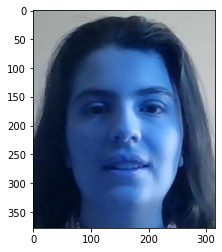

In [ ]:
import cv2
image = cv2.imread('/content/drive/MyDrive/Datasets/image.jpg')
plt.imshow(image)
print(image.shape)

(48, 48, 3)


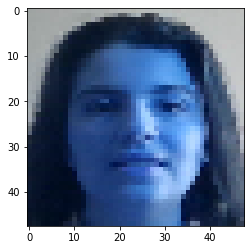

In [ ]:
image = cv2.resize(image, (48, 48))
print(image.shape)
plt.imshow(image)

In [ ]:
dict_label = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}
test_img = np.expand_dims(image, axis = 0) #expand the image 
test_img = test_img.reshape(1,48, 48,3)

In [ ]:
result = model.predict(test_img)
result = list(result[0])

img_index = result.index(max(result))
print(dict_label[img_index])

Sad


In [ ]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Project_I_Computer_Science/vgg16_model') #load the model

In [ ]:
#control the loaded model
result = model.predict(test_img)
result = list(result[0])

img_index = result.index(max(result))
print(dict_label[img_index])

Sad
